Need to import the npu package to be able to use the kernel magic.

In [1]:
import npu

## Kernel Code
The kernel will perform 64x64x64 int8 MACs. It will take at least 1024 cycles to compute.
Duplicating the kernel 3 times so that there's 4 kernel objects. This seems to be necessary so that Riallto can determine that 4 kernels are being used, meaning that you can't just use the same mmul kernel and create a list of it in the NPU graph class constructor.

In [3]:
%%kernel

void mmul_0(uint8_t * __restrict pA, uint8_t * __restrict pB, uint8_t * __restrict pC)
{   
    const int M = 8;
    const int K = 8;
    const int N = 8;
    const int rowA = 64 / M;
    const int colA = 64 / K;
    const int colB = 64 / N;
    using MMUL = ::aie::mmul<M, K, N, uint8_t, uint8_t>;
    
    for (unsigned z = 0; z < rowA; z += 2) chess_prepare_for_pipelining {
        uint8_t * __restrict pC1 = pC + (      z * colB +       0) * MMUL::size_C;
        uint8_t * __restrict pC2 = pC + ((z + 1) * colB +       0) * MMUL::size_C;     
        for (unsigned j = 0; j < colB; j += 2) chess_prepare_for_pipelining {
            const uint8_t * __restrict pA1 = pA + (      z * colA +       0) * MMUL::size_A;
            const uint8_t * __restrict pA2 = pA + ((z + 1) * colA +       0) * MMUL::size_A;
            const uint8_t * __restrict pB1 = pB + (      0 * colB +       j) * MMUL::size_B;
            const uint8_t * __restrict pB2 = pB + (      0 * colB + (j + 1)) * MMUL::size_B;
            ::aie::vector<uint8_t, MMUL::size_A> A0 = ::aie::load_v<MMUL::size_A>(pA1); 
            pA1 += MMUL::size_A;
            ::aie::vector<uint8_t, MMUL::size_A> A1 = ::aie::load_v<MMUL::size_A>(pA2); 
            pA2 += MMUL::size_A;
            ::aie::vector<uint8_t, MMUL::size_B> B0 = ::aie::load_v<MMUL::size_B>(pB1); 
            pB1 += MMUL::size_B * colB;
            ::aie::vector<uint8_t, MMUL::size_B> B1 = ::aie::load_v<MMUL::size_B>(pB2); 
            pB2 += MMUL::size_B * colB;
            
            MMUL C00; 
            C00.mul(A0, B0);
            MMUL C01; 
            C01.mul(A0, B1);
            MMUL C10; 
            C10.mul(A1, B0);
            MMUL C11; 
            C11.mul(A1, B1);
            
            for (unsigned i = 1; i < colA; ++i) chess_prepare_for_pipelining {
                A0 = ::aie::load_v<MMUL::size_A>(pA1); 
                pA1 += MMUL::size_A;
                A1 = ::aie::load_v<MMUL::size_A>(pA2);
                pA2 += MMUL::size_A;
                B0 = ::aie::load_v<MMUL::size_B>(pB1); 
                pB1 += MMUL::size_B * colB;
                B1 = ::aie::load_v<MMUL::size_B>(pB2); 
                pB2 += MMUL::size_B * colB;
                
                C00.mac(A0, B0);
                C01.mac(A0, B1);
                C10.mac(A1, B0);
                C11.mac(A1, B1);
            }

            ::aie::store_v(pC1, C00.template to_vector<uint8_t>()); 
            pC1 += MMUL::size_C;
            ::aie::store_v(pC1, C01.template to_vector<uint8_t>()); 
            pC1 += MMUL::size_C;
            ::aie::store_v(pC2, C10.template to_vector<uint8_t>()); 
            pC2 += MMUL::size_C;
            ::aie::store_v(pC2, C11.template to_vector<uint8_t>()); 
            pC2 += MMUL::size_C;
        }
    }
}

In [4]:
%%kernel

void mmul_1(uint8_t * __restrict pA, uint8_t * __restrict pB, uint8_t * __restrict pC)
{   
    const int M = 8;
    const int K = 8;
    const int N = 8;
    const int rowA = 64 / M;
    const int colA = 64 / K;
    const int colB = 64 / N;
    using MMUL = ::aie::mmul<M, K, N, uint8_t, uint8_t>;
    
    for (unsigned z = 0; z < rowA; z += 2) chess_prepare_for_pipelining {
        uint8_t * __restrict pC1 = pC + (      z * colB +       0) * MMUL::size_C;
        uint8_t * __restrict pC2 = pC + ((z + 1) * colB +       0) * MMUL::size_C;     
        for (unsigned j = 0; j < colB; j += 2) chess_prepare_for_pipelining {
            const uint8_t * __restrict pA1 = pA + (      z * colA +       0) * MMUL::size_A;
            const uint8_t * __restrict pA2 = pA + ((z + 1) * colA +       0) * MMUL::size_A;
            const uint8_t * __restrict pB1 = pB + (      0 * colB +       j) * MMUL::size_B;
            const uint8_t * __restrict pB2 = pB + (      0 * colB + (j + 1)) * MMUL::size_B;
            ::aie::vector<uint8_t, MMUL::size_A> A0 = ::aie::load_v<MMUL::size_A>(pA1); 
            pA1 += MMUL::size_A;
            ::aie::vector<uint8_t, MMUL::size_A> A1 = ::aie::load_v<MMUL::size_A>(pA2); 
            pA2 += MMUL::size_A;
            ::aie::vector<uint8_t, MMUL::size_B> B0 = ::aie::load_v<MMUL::size_B>(pB1); 
            pB1 += MMUL::size_B * colB;
            ::aie::vector<uint8_t, MMUL::size_B> B1 = ::aie::load_v<MMUL::size_B>(pB2); 
            pB2 += MMUL::size_B * colB;
            
            MMUL C00; 
            C00.mul(A0, B0);
            MMUL C01; 
            C01.mul(A0, B1);
            MMUL C10; 
            C10.mul(A1, B0);
            MMUL C11; 
            C11.mul(A1, B1);
            
            for (unsigned i = 1; i < colA; ++i) chess_prepare_for_pipelining {
                A0 = ::aie::load_v<MMUL::size_A>(pA1); 
                pA1 += MMUL::size_A;
                A1 = ::aie::load_v<MMUL::size_A>(pA2);
                pA2 += MMUL::size_A;
                B0 = ::aie::load_v<MMUL::size_B>(pB1); 
                pB1 += MMUL::size_B * colB;
                B1 = ::aie::load_v<MMUL::size_B>(pB2); 
                pB2 += MMUL::size_B * colB;
                
                C00.mac(A0, B0);
                C01.mac(A0, B1);
                C10.mac(A1, B0);
                C11.mac(A1, B1);
            }

            ::aie::store_v(pC1, C00.template to_vector<uint8_t>()); 
            pC1 += MMUL::size_C;
            ::aie::store_v(pC1, C01.template to_vector<uint8_t>()); 
            pC1 += MMUL::size_C;
            ::aie::store_v(pC2, C10.template to_vector<uint8_t>()); 
            pC2 += MMUL::size_C;
            ::aie::store_v(pC2, C11.template to_vector<uint8_t>()); 
            pC2 += MMUL::size_C;
        }
    }
}

In [5]:
%%kernel

void mmul_2(uint8_t * __restrict pA, uint8_t * __restrict pB, uint8_t * __restrict pC)
{   
    const int M = 8;
    const int K = 8;
    const int N = 8;
    const int rowA = 64 / M;
    const int colA = 64 / K;
    const int colB = 64 / N;
    using MMUL = ::aie::mmul<M, K, N, uint8_t, uint8_t>;
    
    for (unsigned z = 0; z < rowA; z += 2) chess_prepare_for_pipelining {
        uint8_t * __restrict pC1 = pC + (      z * colB +       0) * MMUL::size_C;
        uint8_t * __restrict pC2 = pC + ((z + 1) * colB +       0) * MMUL::size_C;     
        for (unsigned j = 0; j < colB; j += 2) chess_prepare_for_pipelining {
            const uint8_t * __restrict pA1 = pA + (      z * colA +       0) * MMUL::size_A;
            const uint8_t * __restrict pA2 = pA + ((z + 1) * colA +       0) * MMUL::size_A;
            const uint8_t * __restrict pB1 = pB + (      0 * colB +       j) * MMUL::size_B;
            const uint8_t * __restrict pB2 = pB + (      0 * colB + (j + 1)) * MMUL::size_B;
            ::aie::vector<uint8_t, MMUL::size_A> A0 = ::aie::load_v<MMUL::size_A>(pA1); 
            pA1 += MMUL::size_A;
            ::aie::vector<uint8_t, MMUL::size_A> A1 = ::aie::load_v<MMUL::size_A>(pA2); 
            pA2 += MMUL::size_A;
            ::aie::vector<uint8_t, MMUL::size_B> B0 = ::aie::load_v<MMUL::size_B>(pB1); 
            pB1 += MMUL::size_B * colB;
            ::aie::vector<uint8_t, MMUL::size_B> B1 = ::aie::load_v<MMUL::size_B>(pB2); 
            pB2 += MMUL::size_B * colB;
            
            MMUL C00; 
            C00.mul(A0, B0);
            MMUL C01; 
            C01.mul(A0, B1);
            MMUL C10; 
            C10.mul(A1, B0);
            MMUL C11; 
            C11.mul(A1, B1);
            
            for (unsigned i = 1; i < colA; ++i) chess_prepare_for_pipelining {
                A0 = ::aie::load_v<MMUL::size_A>(pA1); 
                pA1 += MMUL::size_A;
                A1 = ::aie::load_v<MMUL::size_A>(pA2);
                pA2 += MMUL::size_A;
                B0 = ::aie::load_v<MMUL::size_B>(pB1); 
                pB1 += MMUL::size_B * colB;
                B1 = ::aie::load_v<MMUL::size_B>(pB2); 
                pB2 += MMUL::size_B * colB;
                
                C00.mac(A0, B0);
                C01.mac(A0, B1);
                C10.mac(A1, B0);
                C11.mac(A1, B1);
            }

            ::aie::store_v(pC1, C00.template to_vector<uint8_t>()); 
            pC1 += MMUL::size_C;
            ::aie::store_v(pC1, C01.template to_vector<uint8_t>()); 
            pC1 += MMUL::size_C;
            ::aie::store_v(pC2, C10.template to_vector<uint8_t>()); 
            pC2 += MMUL::size_C;
            ::aie::store_v(pC2, C11.template to_vector<uint8_t>()); 
            pC2 += MMUL::size_C;
        }
    }
}

In [6]:
%%kernel

void mmul_3(uint8_t * __restrict pA, uint8_t * __restrict pB, uint8_t * __restrict pC)
{   
    const int M = 8;
    const int K = 8;
    const int N = 8;
    const int rowA = 64 / M;
    const int colA = 64 / K;
    const int colB = 64 / N;
    using MMUL = ::aie::mmul<M, K, N, uint8_t, uint8_t>;
    
    for (unsigned z = 0; z < rowA; z += 2) chess_prepare_for_pipelining {
        uint8_t * __restrict pC1 = pC + (      z * colB +       0) * MMUL::size_C;
        uint8_t * __restrict pC2 = pC + ((z + 1) * colB +       0) * MMUL::size_C;     
        for (unsigned j = 0; j < colB; j += 2) chess_prepare_for_pipelining {
            const uint8_t * __restrict pA1 = pA + (      z * colA +       0) * MMUL::size_A;
            const uint8_t * __restrict pA2 = pA + ((z + 1) * colA +       0) * MMUL::size_A;
            const uint8_t * __restrict pB1 = pB + (      0 * colB +       j) * MMUL::size_B;
            const uint8_t * __restrict pB2 = pB + (      0 * colB + (j + 1)) * MMUL::size_B;
            ::aie::vector<uint8_t, MMUL::size_A> A0 = ::aie::load_v<MMUL::size_A>(pA1); 
            pA1 += MMUL::size_A;
            ::aie::vector<uint8_t, MMUL::size_A> A1 = ::aie::load_v<MMUL::size_A>(pA2); 
            pA2 += MMUL::size_A;
            ::aie::vector<uint8_t, MMUL::size_B> B0 = ::aie::load_v<MMUL::size_B>(pB1); 
            pB1 += MMUL::size_B * colB;
            ::aie::vector<uint8_t, MMUL::size_B> B1 = ::aie::load_v<MMUL::size_B>(pB2); 
            pB2 += MMUL::size_B * colB;
            
            MMUL C00; 
            C00.mul(A0, B0);
            MMUL C01; 
            C01.mul(A0, B1);
            MMUL C10; 
            C10.mul(A1, B0);
            MMUL C11; 
            C11.mul(A1, B1);
            
            for (unsigned i = 1; i < colA; ++i) chess_prepare_for_pipelining {
                A0 = ::aie::load_v<MMUL::size_A>(pA1); 
                pA1 += MMUL::size_A;
                A1 = ::aie::load_v<MMUL::size_A>(pA2);
                pA2 += MMUL::size_A;
                B0 = ::aie::load_v<MMUL::size_B>(pB1); 
                pB1 += MMUL::size_B * colB;
                B1 = ::aie::load_v<MMUL::size_B>(pB2); 
                pB2 += MMUL::size_B * colB;
                
                C00.mac(A0, B0);
                C01.mac(A0, B1);
                C10.mac(A1, B0);
                C11.mac(A1, B1);
            }

            ::aie::store_v(pC1, C00.template to_vector<uint8_t>()); 
            pC1 += MMUL::size_C;
            ::aie::store_v(pC1, C01.template to_vector<uint8_t>()); 
            pC1 += MMUL::size_C;
            ::aie::store_v(pC2, C10.template to_vector<uint8_t>()); 
            pC2 += MMUL::size_C;
            ::aie::store_v(pC2, C11.template to_vector<uint8_t>()); 
            pC2 += MMUL::size_C;
        }
    }
}

In [7]:
# Check the kernel has been created and is a Kernel type
mmul_0

In [8]:
# Check the kernel source code
print(mmul_0.srccode)


#define NOCPP
#include <stdint.h>
#include <stdio.h>
#include <stdlib.h>
#define REL_WRITE 0
#define REL_READ 1
#include <aie_api/aie.hpp>

        

extern "C" {
void mmul_0(uint8_t * __restrict pA, uint8_t * __restrict pB, uint8_t * __restrict pC)
{   
    const int M = 8;
    const int K = 8;
    const int N = 8;
    const int rowA = 64 / M;
    const int colA = 64 / K;
    const int colB = 64 / N;
    using MMUL = ::aie::mmul<M, K, N, uint8_t, uint8_t>;
    
    for (unsigned z = 0; z < rowA; z += 2) chess_prepare_for_pipelining {
        uint8_t * __restrict pC1 = pC + (      z * colB +       0) * MMUL::size_C;
        uint8_t * __restrict pC2 = pC + ((z + 1) * colB +       0) * MMUL::size_C;     
        for (unsigned j = 0; j < colB; j += 2) chess_prepare_for_pipelining {
            const uint8_t * __restrict pA1 = pA + (      z * colA +       0) * MMUL::size_A;
            const uint8_t * __restrict pA2 = pA + ((z + 1) * colA +       0) * MMUL::size_A;
            const uint8

In [9]:
# Check the buffers that were created
mmul_0.metadata

{'name': 'mmul_0_1',
 'tloc': None,
 'ttype': 'CT',
 'ktype': 'mmul_0',
 'type': 'CT',
 'ports': {'pA': {'c_dtype': None,
   'direction': None,
   'name': 'pA',
   'ctype': None,
   'shape': None,
   'dtype': None},
  'pB': {'c_dtype': None,
   'direction': None,
   'name': 'pB',
   'ctype': None,
   'shape': None,
   'dtype': None},
  'pC': {'c_dtype': None,
   'direction': None,
   'name': 'pC',
   'ctype': None,
   'shape': None,
   'dtype': None}}}

## NPU Graph
Create a class for specifying the NPU graph.

In [10]:
import numpy as np

from npu.build.appbuilder import AppBuilder
from npu.build.kernel import Kernel
from npu.build.mtkernel import MTSplit, MTConcat
from npu.build.itkernel import ITWrite, ITRead


class Mmul(AppBuilder):

    def __init__(self, kernel_0: Kernel, kernel_1: Kernel, kernel_2: Kernel, kernel_3: Kernel):
        self.kernel_list = [kernel_0, kernel_1, kernel_2, kernel_3]
        self.mtbsplit = MTSplit(4)
        self.mtbconcat = MTConcat()
        super().__init__()

    def callgraph(self, mtx_a: np.ndarray, mtx_b: np.ndarray, mtx_c: np.ndarray) -> None:
        kernel_outputs = [None] * 4
        input_a = ITRead(mtx_a)
        input_b = self.mtbsplit(mtx_b) 
        for i in range(4):
            kernel_outputs[i] = self.kernel_list[i](input_a, input_b[i])
        mtbuffer_out = self.mtbconcat(kernel_outputs)
        _ = ITWrite(mtbuffer_out, bufref=mtx_c)

In [11]:
import numpy as np

from npu.build.appbuilder import AppBuilder
from npu.build.kernel import Kernel

# Create an instance of the applicaiton
app_builder = Mmul(kernel_0=mmul_0, kernel_1=mmul_1, kernel_2=mmul_2, kernel_3=mmul_3)

# Trace the callgraph
# Seems like memory tile only splits in the first dimension
mtx_a = np.zeros(shape=(64, 64), dtype=np.uint8)
mtx_b = np.zeros(shape=(4*64, 64), dtype=np.uint8)
mtx_c = np.zeros(shape=(4*64, 64), dtype=np.uint8)

# Define array size of pC to help the compiler determine the shape of the buffer
# Skipping this could cause a RuntimeError
for i in range(4):
    app_builder.kernel_list[i].pC.array = np.ndarray(shape=(64, 64), dtype=np.uint8)
app_builder(mtx_a, mtx_b, mtx_c)

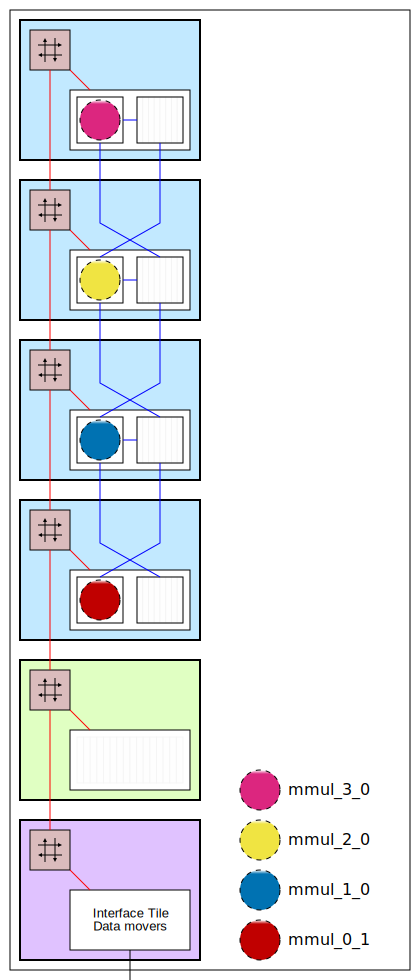

In [12]:
app_builder.display()

In [13]:
app_builder.build(mtx_a, mtx_b, mtx_c, debug=True, mlir="Mmul.mlir") 

Using cached mmul_0 kernel object file...


Using cached mmul_1 kernel object file...


Using cached mmul_2 kernel object file...


Using cached mmul_3 kernel object file...


Building the xclbin...

RTNETLINK answers: File exists
chess-clang: warning: argument unused during compilation: '-I /opt/tools/Vitis/2023.1/aietools/data/aie_ml/lib' [-Wunused-command-line-argument]
chess-clang: warning: argument unused during compilation: '-I /opt/tools/Vitis/2023.1/aietools/data/aie_ml/lib/runtime_cxx/libcxx-lite/include' [-Wunused-command-line-argument]
chess-clang: warning: argument unused during compilation: '-I /opt/tools/Vitis/2023.1/aietools/data/aie_ml/lib/runtime_cxx/libs/libcxx-9.0.0/include-lite' [-Wunused-command-line-argument]
chess-clang: warning: argument unused during compilation: '-I /opt/tools/Vitis/2023.1/aietools/data/aie_ml/lib/runtime/include' [-Wunused-command-line-argument]
chess-clang: warning: argument unused during compilation: '-I <BOOST_DIR>' [-Wunused-command-line-

In [14]:
app_builder.metadata

{'application': 'Mmul',
 'kernels': OrderedDict([('itbuffer_0',
               {'name': 'itbuffer_0',
                'tloc': None,
                'ttype': 'IT',
                'ktype': 'buffer',
                'type': 'IT',
                'ports': {'ITin': {'c_dtype': None,
                  'direction': 'in',
                  'name': 'ITin',
                  'ctype': None,
                  'shape': (64, 64),
                  'dtype': 'uint8'},
                 'ITout': {'c_dtype': None,
                  'direction': 'out',
                  'name': 'ITout',
                  'ctype': None,
                  'shape': (64, 64),
                  'dtype': 'uint8'}},
                'shape': (64, 64),
                'dtype': 'uint8'}),
              ('itbuffer_1',
               {'name': 'itbuffer_1',
                'tloc': None,
                'ttype': 'IT',
                'ktype': 'buffer',
                'type': 'IT',
                'ports': {'ITin': {'c_dtype': None,
 

## Application Code

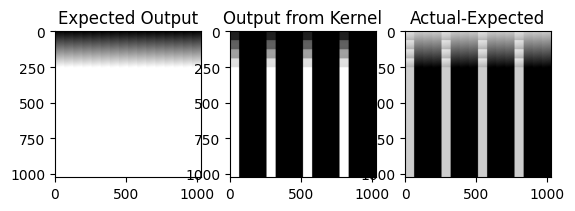

Application performance:
Checking for error in kernel calculation: Min(Actual-Expected)=-255, Max(Actual-Expected)=63
total kernel calculation time (without tiling overhead)=0.4244556427001953
total cpu calculation time=5.792945623397827


In [1]:
import numpy as np
import time

import matplotlib.pyplot as plt
from npu.runtime import AppRunner


def partition_matrix(matrix, tile_size):
    rows, cols = matrix.shape
    tile_rows, tile_cols = tile_size
    tiled_matrix = (matrix.reshape(rows // tile_rows, tile_rows, cols // tile_cols, tile_cols).
            swapaxes(1, 2))
    # Flatten the tiled matrix back to the original shape
    return tiled_matrix.reshape(rows, cols)
    

app = AppRunner('Mmul.xclbin')

# AIE mmul API configuration. 
# The kernel will expect the left matrix to be tiled in (M,K) format
# The kernel will expect the right matrix to be tiled in (K,N) format
# The kernel will output a matrix tiled in (M,N) format
M = 8;
K = 8;
N = 8;

# Allocate app input and output buffers to exchange data with NPU
input_a = app.allocate(shape=(64,64), dtype=np.uint8)
input_b = app.allocate(shape=(4*64,64), dtype=np.uint8)
output_c = app.allocate(shape=(4*64,64), dtype=np.uint8)

# Load array into input buffer
dim = 1024
scaling_factors = np.arange(0, dim)  # Diagonal elements from 0 to dim-1
# Threshold the scaling factor since the arrays are uint8
threshold = 2**8-1
a = np.diag(scaling_factors)
a = np.where(a > threshold, 255, a)
b = np.ones(shape=(dim,dim), dtype=np.uint8)
c = np.zeros(shape=(dim,dim), dtype=np.uint8)
total_time = time.time()-time.time()
num_runs = 1
for _ in range(0, num_runs):
    c = np.zeros(shape=(dim,dim), dtype=np.uint8) # Reset output matrix c to zeros
    for row_a in range(0, a.shape[0], 64):
        for col_b in range(0, b.shape[1], 4*64):
            for col_a in range(0, a.shape[1], 64):
                a_tiled = partition_matrix(a[row_a:row_a+64,col_a:col_a+64], (M,K))
                b_tiled = np.zeros(shape=(4*64,64), dtype=np.uint8)
                for i in range(4):
                    b_tiled[i*64:(i+1)*64,0:64] = partition_matrix(b[col_a:col_a+64,col_b+i*64:col_b+(i+1)*64], (K,N))
                input_a[:] = a_tiled
                input_b[:] = b_tiled
                # Pass input_image buffer to NPU
                input_a.sync_to_npu()
                input_b.sync_to_npu()
    
                # Run app on NPU
                start = time.time()
                app.call(input_a, input_b, output_c)
                total_time = total_time + (time.time() - start)
    
                # Get results from NPU via output_image buffer
                output_c.sync_from_npu()
                for i in range(4):
                    c[row_a:row_a+64,col_b+i*64:col_b+(i+1)*64] = c[row_a:row_a+64,col_b+i*64:col_b+(i+1)*64] + np.array(output_c[i*64:(i+1)*64,0:64])
total_time = total_time / num_runs

# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

# Otain the CPU calculation time. Don't store in an object here
# because the calculation time will go to 0 after the first
# calculation if stored in an object.
start = time.time()
for _ in range(0, num_runs):
    a@b
total_cpu_time = (time.time() - start) / num_runs
expected_output = partition_matrix(a@b, (M,N))

# Display the images. Tile the axb since the output from
# the kernel will be tiled.
ax1.imshow(expected_output, cmap='gray')
ax1.set_title('Expected Output')

ax2.imshow(c, cmap='gray')
ax2.set_title('Output from Kernel')

ax3.imshow(c-expected_output, cmap='gray')
ax3.set_title('Actual-Expected')

# Show the plot
plt.show()

print('Application performance:')
print(f'Checking for error in kernel calculation: Min(Actual-Expected)={np.min(c-expected_output)}, Max(Actual-Expected)={np.max(c-expected_output)}')
print(f'total kernel calculation time (without tiling overhead)={total_time}')
print(f'total cpu calculation time={total_cpu_time}')

Delete the buffers and application, otherwise the application will remain loaded onto the NPU device.

In [2]:
del app